In [1]:
!pip install transformers==4.12.5

# Import necessary libraries

In [2]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup, AutoModel, AutoTokenizer 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

#to_preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
%matplotlib inline
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# identify and specify the GPU as the device, later in training loop we will load data into device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

# Read dataset

In [4]:
# Hugging face dataset
# df_train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt", delimiter=';', header=None, names=['Text','emotion'])
# df_test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt", delimiter=';', header=None, names=['Text','emotion'])
# df_val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt", delimiter=';', header=None, names=['Text','emotion'])
# df = pd.concat([df_train, df_val, df_test], axis = 0)
# Kaggle dataset
df = pd.read_csv("../input/heyooo/out.csv")
df = df.dropna(axis=0)

# Preprocess

In [5]:
# Decontract words im -> i am; didnt -> did not
def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
        
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"wouldnt", "would not", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"cudnt", "could not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesnt", "does not", phrase)
    phrase = re.sub(r"didnt", "did not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"havent", "have not", phrase)
    phrase = re.sub(r"hadnt", "had not", phrase)
    phrase = re.sub(r"neednt", "need not", phrase)
    phrase = re.sub(r"isnt", "is not", phrase)
    phrase = re.sub(r"arent", "are not", phrase)
    phrase = re.sub(r"hasnt", "are not", phrase)
    
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
# Get rid of user handles, tags, link, punctuation
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = decontracted(text)
    return text

In [6]:
# Apple cleaning function for the dataframe
df["Text"] = df["Text"].apply(lambda x: clean_text(x))

In [7]:
# Transform emotion label into encoded label
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['emotion'])
df.rename(columns={'label':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)

In [8]:
# Split dataset
train_text, val_text, train_labels, val_labels = train_test_split(df['Text'], df['label'], 
                                                                    random_state=2021, 
                                                                    test_size=0.1, 
                                                                    stratify=df['label'])


# Generate more data by RandomOverSampler

In [9]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=1)
# train_text, train_labels = ros.fit_resample(np.array(train_text).reshape(-1, 1), np.array(train_labels).reshape(-1, 1))
# t = [s[0] for s in train_text.tolist()]
# train_text = t

# Tokenizer

In [10]:
MAX_LEN = 256
#change to AutoTokenizer if train Bertweet
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", lower = True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# tokenize and encode sequences in the training set (for Bertbase fine tuning)
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LEN,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
# For Bertweet fine tuning
# # tokenize and encode sequences in the training set
# tokens_train = tokenizer.batch_encode_plus(
#     train_text,
#     padding='longest',
#     truncation=True,
#     return_token_type_ids=False
# )

# # tokenize and encode sequences in the validation set
# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     padding='longest',
#     truncation=True,
#     return_token_type_ids=False
# )


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Create iterator of data with DataLoader

In [12]:
# for train set
train_inputs = torch.tensor(tokens_train['input_ids'])
train_y = torch.tensor(train_labels.tolist())
train_masks = torch.tensor(tokens_train['attention_mask'])


# for validation set
val_inputs = torch.tensor(tokens_val['input_ids'])
val_y = torch.tensor(val_labels.tolist())
val_masks = torch.tensor(tokens_val['attention_mask'])

batch_size = 32
train_data = TensorDataset(train_inputs,train_masks,train_y)
train_sampler =  RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs,val_masks,val_y)
val_sampler =  RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Load model

In [13]:
from transformers import BertModel
# Use AutoModel for Bertweet
# bert = AutoModel.from_pretrained("vinai/bertweet-base").to(device)
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Add fully connected layer on top of the pretrained BERT

In [14]:
class BERT_14(torch.nn.Module):

    def __init__(self, bert):
      super(BERT_14, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = torch.nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  torch.nn.ReLU()

      # dense layer 1
      self.fc1 = torch.nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = torch.nn.Linear(512,6)


    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      output = self.bert(sent_id,attention_mask=mask)
      x = output[0][:, 0, :]
      x = self.fc1(x)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
#       # apply softmax activation
#       x = F.softmax(x, dim = 1)

      return x

In [15]:
model = BERT_14(bert)
model.to(device)

BERT_14(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

# Instantiate optimizer and scheduler 

In [16]:
epochs = 4
optimizer = AdamW(model.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
num_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=num_steps)

# Training

In [17]:

criteria = torch.nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader, epochs):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch in range(epochs):
        total_loss, batch_loss, batch_counts = 0, 0, 0

        model.train()
        best = 0
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            optimizer.zero_grad()

            logits = model(b_input_ids, b_attn_mask)

            loss = criteria(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
            if step % 50 == 0:
                # Calculate time elapsed for 20 batches

                # Print training results
                print("Train:Epoch ", epoch, ": ", batch_loss/batch_counts) 
                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        val_loss, val_accuracy = evaluate(model, val_dataloader)
        if val_accuracy > best:
            best = val_accuracy
            model_save_name = 'fineTuneModel.bin'
            path = path_model = F'/kaggle/working/{model_save_name}'
            torch.save(model.state_dict(),path);
        print("Val loss: ",val_loss,"; Val accuracy: ", val_accuracy)

def evaluate(model, val_dataloader):
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = criteria(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [18]:
train(model, train_dataloader, val_dataloader, epochs=4)

Start training...

Train:Epoch  0 :  1.8096983432769775
Train:Epoch  0 :  1.5686814618110656
Train:Epoch  0 :  1.318698399066925
Train:Epoch  0 :  1.1949644374847412
Train:Epoch  0 :  1.1356697273254395
Train:Epoch  0 :  1.0901631700992584
Train:Epoch  0 :  1.0976531767845155
Train:Epoch  0 :  1.0948627483844757
Train:Epoch  0 :  1.0352133691310883
Train:Epoch  0 :  1.0410805356502533
Train:Epoch  0 :  1.0359325444698333
Train:Epoch  0 :  1.0541309416294098
Train:Epoch  0 :  1.0413427770137786
Train:Epoch  0 :  1.0158919978141785
Train:Epoch  0 :  1.022891228199005
Train:Epoch  0 :  1.0221161258220672
Train:Epoch  0 :  1.0059745848178863
Train:Epoch  0 :  1.0474246454238891
Train:Epoch  0 :  1.024891527891159
Val loss:  0.98175448651361 ; Val accuracy:  63.65511551155116
Train:Epoch  1 :  0.8272722959518433
Train:Epoch  1 :  0.8016420602798462
Train:Epoch  1 :  0.7723849380016327
Train:Epoch  1 :  0.747272869348526
Train:Epoch  1 :  0.7729968589544296
Train:Epoch  1 :  0.79755443572998

# Save model

In [19]:

model_save_name = 'fineTuneModel.bin'
path = F'/kaggle/working/{model_save_name}'
torch.save(model.state_dict(),path);

# Load model

In [20]:
model = BERT_14(bert)
model.load_state_dict(torch.load("./fineTuneModel.bin"))
model.to(device)

BERT_14(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

# Quantitative evaluation

In [21]:
save = []
for batch in val_dataloader:
    b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
    with torch.no_grad():
        logits = model(b_input_ids, b_attn_mask)
    predict = logits.to("cpu").numpy()
    predict = np.argmax(predict, axis=1).flatten()
    labels_flat = b_labels.to("cpu").numpy().flatten()
    temp = pd.DataFrame({'Actual_class':labels_flat,'Predicted_class':predict})
    save.append(temp)
    

In [22]:
# save = []
# for batch in val_dataloader:
#     b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
#     with torch.no_grad():
#         logits = model(b_input_ids, b_attn_mask)
#     predict = logits.to("cpu").numpy()
#     predict = np.argmax(predict, axis=1).flatten()
#     labels_flat = b_labels.to("cpu").numpy().flatten()
#     temp = pd.DataFrame({'Actual_class':labels_flat,'Predicted_class':predict})
#     save.append(temp)

In [23]:
## emotion labels
label2int = {
  "sadness": 4,
  "joy": 2,
  "anger": 0,
  "fear": 1,
  "surprise": 5,
  "love": 3
}

In [24]:
df_metrics = pd.concat(save, axis = 0)
df_metrics = df_metrics.reset_index()

In [25]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

     sadness   0.754717  0.725624  0.739884       441
         joy   0.829630  0.828096  0.828862       541
       anger   0.548732  0.587983  0.567680       699
        fear   0.526786  0.460938  0.491667       384
    surprise   0.591078  0.616279  0.603416       516
        love   0.560582  0.555200  0.557878       625

    accuracy                       0.630381      3206
   macro avg   0.635254  0.629020  0.631564      3206
weighted avg   0.630963  0.630381  0.630177      3206



In [26]:
from sklearn.metrics import accuracy_score,matthews_corrcoef
print(accuracy_score(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values))
print(matthews_corrcoef(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values))

0.6303805364940737
0.5522949338113854


In [27]:
# from sklearn.metrics import classification_report
# with torch.no_grad():
#   preds = model(val_inputs.to(device),val_masks.to(device))
#   preds = preds.detach().cpu().numpy()
# preds = np.argmax(preds, axis = 1)
# print(classification_report(val_y, preds))

In [28]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values)

<AxesSubplot:>

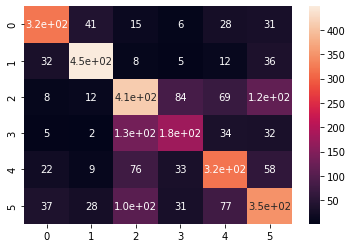

In [29]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [30]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

# Qualitative evaluation

In [31]:
def preprocessing(text):
    input_id = tokenizer.encode(text, add_special_tokens=True,padding='longest',truncation=True,return_token_type_ids=False)
    attention = [float(i>0) for i in input_id]
    input_id = torch.tensor([input_id]).to(device)
    attention = torch.tensor([attention]).to(device)
    return input_id, attention

In [32]:
text = clean_text("I can tell her about the subject")
input, attention = preprocessing(text)
result = model(input, attention)
print(result)

tensor([[ 0.1966,  0.9516, -0.0852, -0.8451, -0.7928,  0.5988]],
       device='cuda:0', grad_fn=<AddmmBackward>)
